In [7]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import font_manager
from tueplots import bundles
from tueplots.constants.color import rgb
from tueplots import figsizes, fonts

from utils import jasonlines_to_panda_df, generate_sample_df, get_fallout_4_df, filter_string, preprocess_df, analyze_reviews, filter_peaks

In [2]:
display(bundles.icml2022(column='full',nrows=1,ncols=1,usetex=False))

plt.rcParams.update(bundles.icml2022(column='full',nrows=1,ncols=1,usetex=False))
#matplotlib.rcParams['font.family'] = times_prop.get_name()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['figure.figsize'] = (9.1, 2.8)

#print(plt.rcParams)

{'text.usetex': False,
 'font.serif': ['Times'],
 'mathtext.fontset': 'stix',
 'mathtext.rm': 'Times',
 'mathtext.it': 'Times:italic',
 'mathtext.bf': 'Times:bold',
 'font.family': 'serif',
 'figure.figsize': (6.75, 4.171729424061791),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

In [3]:
def plot_most_interesting(df_dict_pos, df_dict_neg, word_plot_name='test_word_plot', max_df=1.0, min_df=20, ngram_range=(1,1), thresh_rel_diff=0.4, thresh_rel=0.0):
    df_list_processed_pos = []
    df_list_processed_neg = []
    game_list_pos = []
    game_list_neg = []
    
    for game in df_dict_pos.keys():
        game_list_pos.append(game)
        df = preprocess_df(df_dict_pos[game])

        rt_df_count, rt_df_tfidf = analyze_reviews(df, max_df=max_df, min_df=min_df, ngram_range=ngram_range)

        sum_df = filter_peaks(rt_df_count, thresh_rel_diff=thresh_rel_diff)
        #filter out keyword "game" as it appears so frequently and is not informative
        if sum_df.index.isin(['game']).any():
            sum_df.drop(index='game', inplace=True)
            
        #rename columns to include name of game
        sum_df.rename(columns={"neg": (game + "_neg"), "pos": (game + "_pos"), "rel_diff": (game + "_rel_diff"), "neg_rel_app": (game + "_neg_rel_app"), "pos_rel_app": (game + "_pos_rel_app")}, inplace=True)
        df_list_processed_pos.append(sum_df)
        
    for game in df_dict_neg.keys():
        game_list_neg.append(game)
        df = preprocess_df(df_dict_neg[game])

        rt_df_count, rt_df_tfidf = analyze_reviews(df, max_df=max_df, min_df=min_df, ngram_range=ngram_range)

        sum_df = filter_peaks(rt_df_count, thresh_rel_diff=thresh_rel_diff)
        #filter out keyword "game" as it appears so frequently and is not informative
        if sum_df.index.isin(['game']).any():
            sum_df.drop(index='game', inplace=True)
            
        #rename columns to include name of game
        sum_df.rename(columns={"neg": (game + "_neg"), "pos": (game + "_pos"), "rel_diff": (game + "_rel_diff"), "neg_rel_app": (game + "_neg_rel_app"), "pos_rel_app": (game + "_pos_rel_app")}, inplace=True)
        df_list_processed_neg.append(sum_df)
    
    # calculate mean and max over total and relative appearance of keywords
    joined_df_pos = df_list_processed_pos[0].join(df_list_processed_pos[1:], how="outer")
    joined_df_pos.fillna(0,inplace=True)
    joined_df_pos.sort_index(inplace=True)
    joined_df_pos['mean_neg'] = joined_df_pos.filter(regex='_neg$', axis=1).mean(axis=1)
    joined_df_pos['mean_neg_rel'] = joined_df_pos.filter(regex='_neg_rel_app$', axis=1).mean(axis=1)
    joined_df_pos['neg_rel_app_max'] = joined_df_pos.filter(regex='_neg_rel_app$').max(axis=1)
    joined_df_pos['mean_pos'] = joined_df_pos.filter(regex='_pos$', axis=1).mean(axis=1)
    joined_df_pos['mean_pos_rel'] = joined_df_pos.filter(regex='_pos_rel_app$', axis=1).mean(axis=1)
    joined_df_pos['pos_rel_app_max'] = joined_df_pos.filter(regex='_pos_rel_app$').max(axis=1)
    
    joined_df_neg = df_list_processed_neg[0].join(df_list_processed_neg[1:], how="outer")
    joined_df_neg.fillna(0,inplace=True)
    joined_df_neg.sort_index(inplace=True)
    joined_df_neg['mean_neg'] = joined_df_neg.filter(regex='_neg$', axis=1).mean(axis=1)
    joined_df_neg['mean_neg_rel'] = joined_df_neg.filter(regex='_neg_rel_app$', axis=1).mean(axis=1)
    joined_df_neg['neg_rel_app_max'] = joined_df_neg.filter(regex='_neg_rel_app$').max(axis=1)
    joined_df_neg['mean_pos'] = joined_df_neg.filter(regex='_pos$', axis=1).mean(axis=1)
    joined_df_neg['mean_pos_rel'] = joined_df_neg.filter(regex='_pos_rel_app$', axis=1).mean(axis=1)
    joined_df_neg['pos_rel_app_max'] = joined_df_neg.filter(regex='_pos_rel_app$').max(axis=1)
    
    # filter out keywords according to threshold
    joined_df_pos = joined_df_pos.loc[joined_df_pos['mean_pos'] > 0.0]
    joined_df_pos = joined_df_pos.loc[joined_df_pos['pos_rel_app_max'] > thresh_rel]
    print(joined_df_pos.index)
    joined_df_neg = joined_df_neg.loc[joined_df_neg['mean_neg'] > 0.0]
    joined_df_neg = joined_df_neg.loc[joined_df_neg['neg_rel_app_max'] > thresh_rel]
    print(joined_df_neg.index)
    
    def plot_pos_or_neg(gamelist, gs, joined_df, suffix, color_light, color_dark):
        # plot individual game from dataframe
        axs = gs.subplots(sharex=True, sharey=False)
        spines = ["top","right","left","bottom"]
        for i, game in enumerate(gamelist):
            if i == 0:
                if suffix == '_pos':
                    axs[i].set_title("Keywords in positive reviews")
                else:
                    axs[i].set_title("Keywords in negative reviews")
                    
            y = joined_df[(game+suffix+'_rel_app')]
            x = range(len(y))
            axs[i].plot(
                x,
                y,
                label=game,
                color=color_light,
                alpha = 0.7,
                lw=0.5)
            axs[i].fill_between(
                x = x, 
                y1 = y,
                color =color_light,
                alpha = 0.7)
            rect = axs[i].patch
            rect.set_alpha(0)
            axs[i].set_xticklabels([])
            axs[i].set_xticks([])
            axs[i].grid(
                which="major", axis="x", linestyle="-", linewidth="0.4", color=rgb.tue_gray
            )
            axs[i].set_yticklabels([])
            axs[i].set_yticks([])
            for s in spines:
                axs[i].spines[s].set_visible(False)
            axs[i].legend(loc='center left')
        
        # plot average
        y = joined_df[('mean' + suffix + '_rel')]
        x = range(len(y))
        axs[-1].plot(
            x,
            y,
            label='Average',
            color=color_dark,
            alpha = 0.8,
            lw=0.5)
        axs[-1].fill_between(
            x = x, 
            y1 = y,
            color =color_dark,
            alpha = 0.8)
        rect = axs[-1].patch
        rect.set_alpha(0)
        axs[-1].set_xticks(range(0,len(joined_df.index)))
        axs[-1].set_xticklabels(joined_df.index.values,rotation=90)
        axs[-1].grid(
            which="major", axis="x", linestyle="-", linewidth="0.4", color=rgb.tue_gray
        )
        axs[-1].set_yticklabels([])
        axs[-1].set_yticks([])
        for s in spines:
            axs[-1].spines[s].set_visible(False)
        axs[-1].legend(loc='center left')
    
    
    fig1 = plt.figure()
    gs1 = fig1.add_gridspec((len(game_list_pos)+1))
    plot_pos_or_neg(gamelist=game_list_pos, gs=gs1, joined_df=joined_df_pos, suffix='_pos', color_light=rgb.tue_lightblue, color_dark=rgb.tue_darkblue)
    gs1.update(hspace=-0.4)
    
    plt.savefig(f"{word_plot_name}_pos.pdf")
    
    fig2 = plt.figure()
    gs2 = fig2.add_gridspec((len(game_list_neg)+1))
    plot_pos_or_neg(gamelist=game_list_neg, gs=gs2, joined_df=joined_df_neg, suffix='_neg', color_light=rgb.tue_lightorange, color_dark=rgb.tue_orange)
    gs2.update(hspace=-0.4)
    plt.savefig(f"{word_plot_name}_neg.pdf")
    
    plt.show()

In [4]:
interesting_games_pos = ['Grand_Theft_Auto_V', 'Counter_Strike_Global_Offensive', 'Garrys_Mod']
interesting_games_neg = ['Grand_Theft_Auto_V', 'The_Elder_Scrolls_V', 'Fallout_4']

In [5]:
df_dict_pos = dict()
df_dict_neg = dict()
fraction = 1.0

for game in interesting_games_pos:
    if game=='Fallout_4':
        df_dict_pos[game], choice, n, pos, neg = get_fallout_4_df(fraction=fraction, path='../../dat/additional_games')
    else:
        df_dict_pos[game], choice, n, pos, neg = generate_sample_df(game=game, fraction=fraction, path='../../dat')
    print('{}: choosing {} out of {} reviews. Positive ratio: {}\n'.format(game, choice, n, pos/n))

for game in interesting_games_neg:
    if game=='Fallout_4':
        df_dict_neg[game], choice, n, pos, neg = get_fallout_4_df(fraction=fraction, path='../../dat/additional_games')
    else:
        df_dict_neg[game], choice, n, pos, neg = generate_sample_df(game=game, fraction=fraction, path='../../dat')
    print('{}: choosing {} out of {} reviews. Positive ratio: {}\n'.format(game, choice, n, pos/n))


Grand_Theft_Auto_V: choosing 11190 out of 11190 reviews. Positive ratio: 0.66514745308311

Counter_Strike_Global_Offensive: choosing 5837 out of 5837 reviews. Positive ratio: 0.9498029809833819

Garrys_Mod: choosing 6204 out of 6204 reviews. Positive ratio: 0.9912959381044487

Grand_Theft_Auto_V: choosing 11190 out of 11190 reviews. Positive ratio: 0.66514745308311

The_Elder_Scrolls_V: choosing 6258 out of 6258 reviews. Positive ratio: 0.4741131351869607

Fallout_4: choosing 6120 out of 6120 reviews. Positive ratio: 0.3411764705882353



Index(['1010', 'buy', 'competitive', 'csgo', 'fps', 'friends', 'fun',
       'gamemodes', 'games', 'garry', 'garry mod', 'good', 'graphics', 'great',
       'gta', 'hours', 'mod', 'online', 'pc', 'people', 'play', 'played',
       'playing', 'rockstar', 'sandbox', 'skins', 'story', 'time'],
      dtype='object')
Index(['armor', 'bad', 'bethesda', 'boring', 'building', 'buy', 'character',
       'characters', 'choices', 'combat', 'community', 'dialogue', 'dlc',
       'elements', 'fallout', 'fallout game', 'fallout vegas', 'feel', 'feels',
       'fps', 'fun', 'gameplay', 'games', 'good', 'graphics', 'great', 'gta',
       'hours', 'interesting', 'lot', 'main', 'mod', 'modding', 'mods',
       'money', 'online', 'options', 'paid', 'paid mods', 'pay', 'people',
       'play', 'played', 'playing', 'point', 'power', 'pretty', 'previous',
       'quest', 'quests', 'recommend', 'rockstar', 'rpg', 'series',
       'settlement', 'settlements', 'shooter', 'skyrim', 'steam', 'story',
       'tim

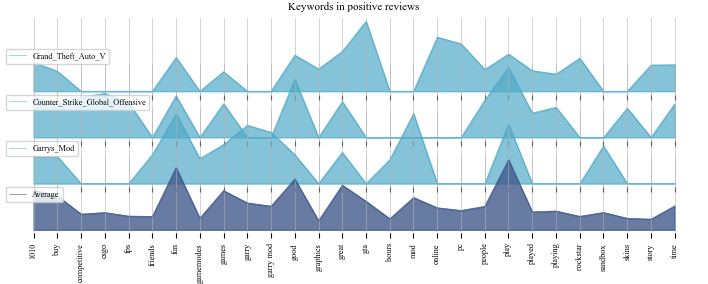

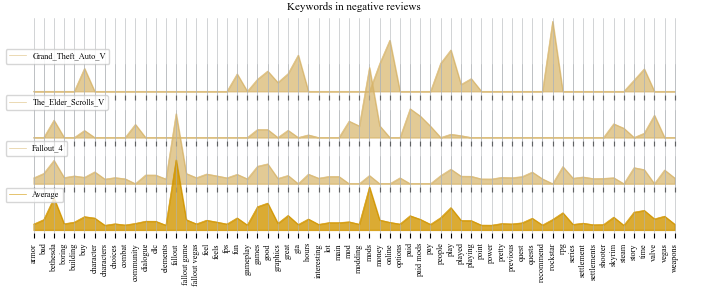

In [6]:
plot_most_interesting(df_dict_pos, df_dict_neg, word_plot_name='wordcount_plot_report', max_df=1.0, min_df=0.08, ngram_range=(1, 2), thresh_rel_diff=0.0, thresh_rel=0.08)